# Design and analyzeof Double MZI
## (After fabrication)

In this Jupyter notebook, the design and analyze of three MZI and a Double-MZI with different phase-shift is presented.

A detailed design procducre is presneted in file [Double_MZI_FINAL_ASP_Submitted_Design_Documented](Double_MZI_FINAL_ASP_Submitted_Design_Documented.ipynb)

Circuit desing Implementation:
- The technology used for constructing the circuits is from Australian Silicon Photonics (ASP) PDK. 
- A standard waveguide template and directional coupler from ASP were used.
- AutoPlaceAndConnect was used to hookup all the circuits.

Analyze the circuit:
- asa

# Circuit Schematic


<img src="images/double_mzi_schematic.png" width=700>

# Design parameters

- First MZI delay length $\Delta L_1 = 15 \mu m$
- Second MZI delay length $\Delta L_1 = 150 \mu m$
- Forth MZI*  delau length $\Delta L_1 = 0.337 \mu m$ 
* The fourth MZI designed to form an MZI that performs resonance at wavelength = 1.55 µm
- Power coupling for the directional couplers: 25%, 50%, 75%


# Design Capture
<img src="images/double_mzi.png" width=800>

In [1]:
%matplotlib notebook

import set_paths
from asp_silicon_photonics import technology 
import all_utils
import ipkiss3.all as i3  # import ipkiss 
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, fixed
from prg_luceda.prg_utils.widgets.progress_callback import ProgressBar
from IPython.display import display
# Load the filter tool box
from asp_silicon_photonics import all as pdk
from addon_luceda.auto_place_and_connect import AutoPlaceAndConnect

In [2]:
import pandas as pd
import os
import numpy as np
import pylab as plt

In [3]:
from IPython.display import FileLinks, display

<IPython.core.display.Javascript object>


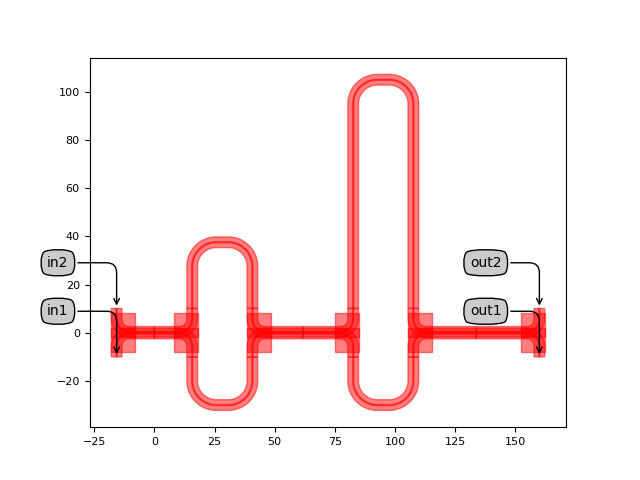

<IPython.core.display.Javascript object>


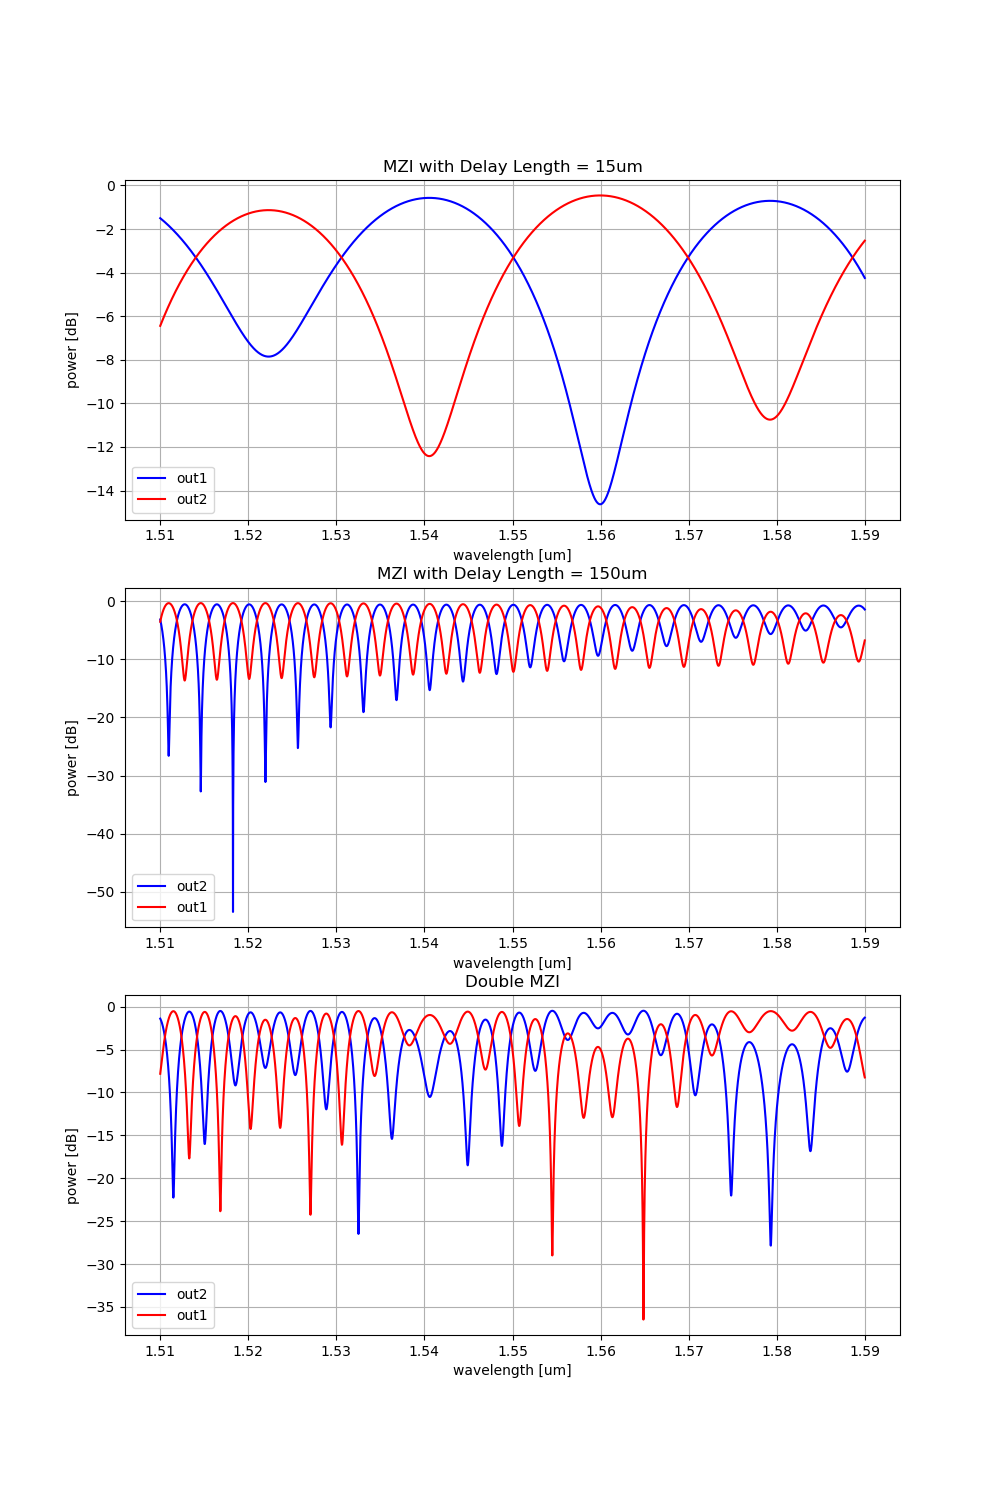

<function matplotlib.pyplot.show>

In [4]:
#Define the delay line of MZI arms
delta_L1 = 15
delta_L2 = 150

#initializing the lower limits (Waveguide & Bend radius of the WGs)
bend_radius=10
wg1_width = 25
wg1a_length = 20

#Wavelengths spec sweep
wavelengths = np.linspace(1.51, 1.59, 3999) 

#Waveguide template configuration.
wt = pdk.WG450()
wt_lo = wt.Layout()
wt_cm = wt.CircuitModel()

#For this device, we need three DC 
#Power coupling for the directional couplers: 25%, 50%, 75%
#The coupling coefficient of the DC defined as following:
k1=0.25
k2=0.5  
k3=0.75 


#First DC defined as "dc1" > that acts as splitter > has k1=0.25 coupling coefficient.
dc1 = pdk.Bend90DirectionalCoupler(name="dc1",
                                      trace_template1=wt,
                                      coupling=k1)
dc1_lo = dc1.Layout(manhattan=True)
#dc1_lo.visualize(annotate=True)

#The first MZI arm configuration 
#The lower-arm one is defined as wg1a
start_point = dc1_lo.ports["out1"].position
mid_point1 = start_point.move_copy((0.0, -wg1a_length))
mid_point2 = mid_point1.move_copy((wg1_width, 0.0))
end_point = mid_point2.move_copy((0.0, wg1a_length))

control_shape = i3.Shape([start_point, mid_point1, mid_point2, end_point])

wg1a = i3.RoundedWaveguide(name="wg1a",
                         trace_template=wt)

wg1a_lo = wg1a.Layout(shape=control_shape,bend_radius=bend_radius)
wg1a_len = wg1a_lo.trace_length()
#wg1a_lo.visualize(annotate=1)

#The upper-arm one is defined as wg1b
start_point = dc1_lo.ports["out2"].position #starting point is the output of port > out2
mid_point1 = start_point.move_copy((0.0,(wg1a_length)+(0.5*delta_L1))) # here we apply the shift for the delay
mid_point2 = mid_point1.move_copy((wg1_width,0.0))
end_point = mid_point2.move_copy((0.0,-(wg1a_length)-(0.5*delta_L1))) #End point

control_shape = i3.Shape([start_point, mid_point1, mid_point2, end_point])

wg1b = i3.RoundedWaveguide(name="wg1b",
                         trace_template=wt)
wg1b_lo = wg1b.Layout(shape=control_shape,bend_radius=bend_radius)
#wg1b_lo.visualize()

wg1b_len = wg1b_lo.trace_length()
L1_delta = wg1b_len - wg1a_len
#print "delta_L1 = ",L1_delta  #Verify delay-line


#Second DC defined as "dc2"> that will act as combiner > has k2=0.5 coupling coefficient.
dc2 = pdk.Bend90DirectionalCoupler(name="dc2",
                                      trace_template1=wt,
                                      coupling=k2) 
dc2_lo = dc2.Layout(manhattan=True)
#dc2_lo.visualize(annotate=True)


#Forming the first MZI > that has delay length > delta_L1= 15um
MZI_1 = AutoPlaceAndConnect(child_cells={"splitter": dc1,
                                        "combiner": dc2,
                                        "wg1b": wg1b,
                                        "wg1a": wg1a,
                                       },
                           links=[("splitter:out2", "wg1b:in"),
                                  ("wg1b:out", "combiner:in2"),
                                  ("splitter:out1","wg1a:in"),
                                  ("wg1a:out","combiner:in1")
                                 ],
                           external_port_names={"splitter:in2": "in2",
                                                "splitter:in1": "in1",
                                                "combiner:out2": "out2",
                                                "combiner:out1": "out1" })
# MZI_1_lo = MZI_1.Layout()
# MZI_1_lo.visualize(annotate=True)

#Analyze the first MZI > that has delay length > delta_L1= 15um
MZI_1_cm = MZI_1.CircuitModel() 

S_MZI_1 = MZI_1_cm.get_smatrix(wavelengths)

#Second MZI with delay length  = 150um

#Splitter defined as "dc3" > has coupling k3=0.75
dc3 = pdk.Bend90DirectionalCoupler(name="dc3",
                                      trace_template1=wt,
                                      coupling=k3)
dc3_lo = dc3.Layout(manhattan=True)
# dc3_lo.visualize(annotate=True)

#The second MZI arm configuration, delay length  = 150um

#The lower-arm one is defined as wg2a
start_point = dc3_lo.ports["out1"].position
mid_point1 = start_point.move_copy((0.0, -wg1a_length))
mid_point2 = mid_point1.move_copy((wg1_width, 0.0))
end_point = mid_point2.move_copy((0.0, wg1a_length))

control_shape = i3.Shape([start_point, mid_point1, mid_point2, end_point])

wg2a = i3.RoundedWaveguide(name="wg2a",
                         trace_template=wt)
wg2a_lo = wg2a.Layout(shape=control_shape,bend_radius=bend_radius)

wg2a_len =  wg2a_lo.trace_length()

# wg2a_lo.visualize(annotate=1) # To plot the arm uncomment the line

#The upper-arm one is defined as wg2b
start_point = dc3_lo.ports["out2"].position
mid_point1 = start_point.move_copy((0.0,wg1a_length+(0.5*delta_L2)))
mid_point2 = mid_point1.move_copy((wg1_width,0.0))
end_point = mid_point2.move_copy((0.0,-wg1a_length-(0.5*delta_L2)))

control_shape = i3.Shape([start_point, mid_point1, mid_point2, end_point])

wg2b = i3.RoundedWaveguide(name="wg2b",
                         trace_template=wt)
wg2b_lo = wg2b.Layout(shape=control_shape,bend_radius=bend_radius)

wg2b_len =  wg2b_lo.trace_length()

# wg2b_lo.visualize()

L1_delta = wg2b_len - wg2a_len  
# print "delta_L1 = ",L1_delta    #To verfiy uncomment the line
 
#Connect the the second MZI 
MZI_2 = AutoPlaceAndConnect(child_cells={"splitter": dc2,
                                        "combiner": dc3,
                                        "wg2b": wg2b,
                                        "wg2a": wg2a,
                                       },
                           links=[("splitter:out2", "wg2b:in"),
                                  ("wg2b:out", "combiner:in2"),
                                  ("splitter:out1","wg2a:in"),
                                  ("wg2a:out","combiner:in1")
                                 ],
                           external_port_names={"splitter:in2": "in2",
                                                "splitter:in1": "in1",
                                                "combiner:out2": "out2",
                                                "combiner:out1": "out1" })
MZI_2_lo = MZI_2.Layout()
# MZI_2_lo.visualize(annotate=True)

#Analyze the second MZI
MZI_2_cm = MZI_2.CircuitModel()

S_MZI_2 = MZI_2_cm.get_smatrix(wavelengths)

#Merging MZI_1 & MZI_2
MZI_Double = AutoPlaceAndConnect(child_cells={"splitter": dc1,
                                        "combiner": dc2,
                                        "wg1b": wg1b,
                                        "wg1a": wg1a,
                                         "wg2b":wg2b,
                                         "wg2a":wg2a,
                                         "dc3":dc3
                                       },
                           links=[("splitter:out2", "wg1b:in"),
                                  ("wg1b:out", "combiner:in2"),
                                  ("splitter:out1","wg1a:in"),
                                  ("wg1a:out","combiner:in1"),
                                  ("wg2b:in","combiner:out2"),
                                  ("wg2a:in","combiner:out1"),
                                  ("dc3:in2","wg2b:out"),
                                  ("dc3:in1","wg2a:out")
                                 ],
                           external_port_names={"splitter:in2": "in2",
                                                "splitter:in1": "in1",
                                                "dc3:out2": "out2",
                                               "dc3:out1":"out1"})
MZI_Double_lo = MZI_Double.Layout()
MZI_Double_lo.visualize(annotate=True)

#Analyze double MZI
MZI_Double_cm = MZI_Double.CircuitModel()
S_MZI_Double = MZI_Double_cm.get_smatrix(wavelengths)


#Ploting the simulation [MZI_1,MZI_2,Double_MZI] 
plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.plot(wavelengths, 10*np.log10(np.abs(S_MZI_1["in1", "out1"])**2),"b", label="out1")
plt.plot(wavelengths, 10*np.log10(np.abs(S_MZI_1["in1", "out2"])**2),"r", label="out2")
plt.xlabel("wavelength [um]")
plt.ylabel("power [dB]")
plt.title("MZI with Delay Length = 15um")
plt.grid()
plt.legend()

plt.subplot(312)
plt.plot(wavelengths, 10*np.log10(np.abs(S_MZI_2["in2", "out2"])**2),"b", label="out2")
plt.plot(wavelengths, 10*np.log10(np.abs(S_MZI_2["in2", "out1"])**2),"r", label="out1")
plt.xlabel("wavelength [um]")
plt.ylabel("power [dB]")
plt.title("MZI with Delay Length = 150um")
plt.grid()
plt.legend()

plt.subplot(313)
plt.plot(wavelengths, 10*np.log10(np.abs(S_MZI_Double["in2", "out2"])**2),"b", label="out2")
plt.plot(wavelengths, 10*np.log10(np.abs(S_MZI_Double["in2", "out1"])**2),"r", label="out1")
plt.xlabel("wavelength [um]")
plt.ylabel("power [dB]")
plt.title("Double MZI")
plt.legend()
plt.grid()
plt.show

In [5]:
dc1_cm = dc1.CircuitModel()
dc2_cm = dc2.CircuitModel()
dc3_cm = dc3.CircuitModel()

In [6]:
print "lumped_coupling =", dc1_cm.lumped_coupling
print "lumped_coupling_deriv1 =", dc1_cm.lumped_coupling_deriv1
print "lumped_coupling_deriv2 =", dc1_cm.lumped_coupling_deriv2
print "specific_coupling =", dc1_cm.specific_coupling
print "specific_coupling_deriv1 =", dc1_cm.specific_coupling_deriv1
print "specific_coupling_deriv2 =", dc1_cm.specific_coupling_deriv2

lumped_coupling = 0.125
lumped_coupling_deriv1 = 0.75
lumped_coupling_deriv2 = 4.1
specific_coupling = 0.025
specific_coupling_deriv1 = 0.125
specific_coupling_deriv2 = 1.0


In [7]:
lengths = [0.25,0.5,0.75]

components = []



for l in lengths:
    c = pdk.Bend90DirectionalCoupler(
        trace_template1=wt,
        coupling=l)
    components.append(c.CircuitModel())

In [13]:
# components[2].Layout().coupling

<IPython.core.display.Javascript object>


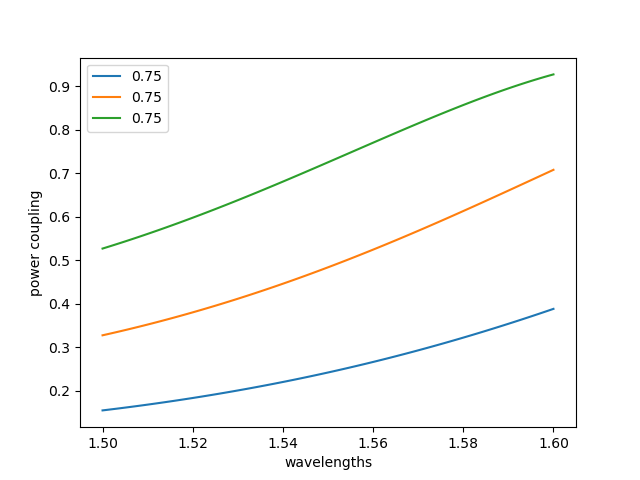

In [8]:
wavelengths = np.linspace(1.5, 1.6, 101)  #only 100 points: the transmission is slowly varying...

transmission_model = []

for c in components:
    S = c.get_smatrix(wavelengths)
    transmission_model.append(np.abs(S['in1', 'out2'])**2)

plt.figure()
for t in transmission_model:
    S = c.get_smatrix(wavelengths)
    plt.plot(wavelengths, t, label=c.coupling)
plt.xlabel('wavelengths')
plt.ylabel('power coupling')
plt.legend()
plt.show()

This is what we expect. The coupling is low for short couplers, and increases when the coupler becomes longer, until it becomes maximal and then decreases again. Also, we see that this effect is stronger for longer wavelengths. This we can intuitively understand: for longer wavelengths the light is less confined in the waveguide core, so it will couple more.

The model parameters for this component are the Taylor coefficients for the `lumped_coupling` and the `specific coupling`:

- $\kappa_0(\lambda_0)$ = `lumped_coupling`

- $\dfrac{\partial \kappa_0}{\partial \lambda}(\lambda_0)$ = `lumped_coupling_deriv1`

- $\dfrac{\partial^2 \kappa_0}{\partial \lambda^2}(\lambda_0)$ = `lumped_coupling_deriv2`

- $k'(\lambda_0)$ = `specific_coupling`

- $\dfrac{\partial \kappa'}{\partial \lambda}(\lambda_0)$ = `specific_coupling_deriv1`

- $\dfrac{\partial^2 \kappa'}{\partial \lambda^2}(\lambda_0)$ = `specific_coupling_deriv2`


In [9]:
cm = components[0] # all components, share the same parameters, except for the coupling

print "lumped_coupling =", cm.lumped_coupling
print "lumped_coupling_deriv1 =", cm.lumped_coupling_deriv1
print "lumped_coupling_deriv2 =", cm.lumped_coupling_deriv2
print "specific_coupling =", cm.specific_coupling
print "specific_coupling_deriv1 =", cm.specific_coupling_deriv1
print "specific_coupling_deriv2 =", cm.specific_coupling_deriv2

lumped_coupling = 0.125
lumped_coupling_deriv1 = 0.75
lumped_coupling_deriv2 = 4.1
specific_coupling = 0.025
specific_coupling_deriv1 = 0.125
specific_coupling_deriv2 = 1.0


<IPython.core.display.Javascript object>


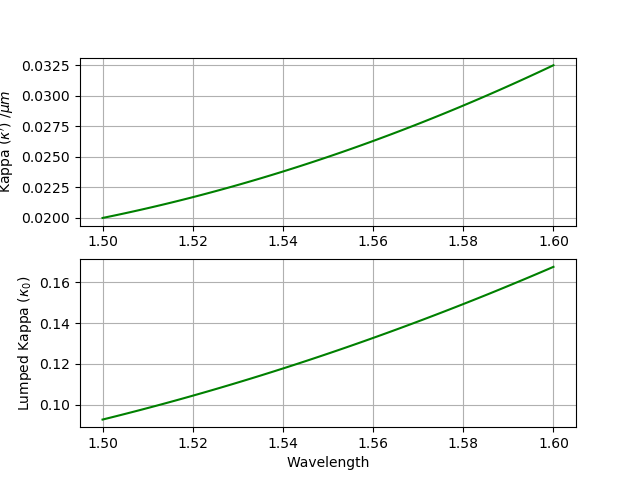

In [10]:
def taylor2(x, val0, deriv1, deriv2, x0):
    """ Taylor expand the coupling coefficients"""
    dx = x-x0
    return val0 + dx * deriv1 + 0.5*dx*dx*deriv2

K0_original = taylor2(wavelengths, cm.lumped_coupling, cm.lumped_coupling_deriv1, cm.lumped_coupling_deriv2, cm.center_wavelength)
K_original = taylor2(wavelengths, cm.specific_coupling, cm.specific_coupling_deriv1, cm.specific_coupling_deriv2, cm.center_wavelength)
    
plt.figure()
plt.subplot(211)
plt.plot(wavelengths, K_original, color='g', label='original')
plt.ylabel("Kappa ($\kappa'$) $/ \mu m$")
plt.grid(True)
plt.subplot(212)
plt.plot(wavelengths, K0_original, color='g', label='original')
plt.xlabel("Wavelength")
plt.ylabel("Lumped Kappa ($\kappa_0$)")
plt.grid(True)

plt.show()

In [11]:
#Analyze

In [11]:
#The Folder containing the measured data on the server is:
folder_name = r'../measurement_data_ASP/chip_A/msc_13'
# Here we imported the folder of the circuits measurements

In [12]:
#Show the files contanined in the folder
display(FileLinks(folder_name))

../measurement_data_ASP/chip_A/msc_13/
  Double_MZI_Halil_De_Broglie_Double_MZI.0_L00_R01.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.3_L00_R01.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.1_L01_R00.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.2_L01_R00.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.2_L00_R01.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.3_L01_R01.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.1_L01_R01.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.1_L00_R00.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.3_L01_R00.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.2_L01_R01.csv
  notebook.tar.gz
  Double_MZI_Halil_De_Broglie_Double_MZI.2_L00_R00.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.0_L00_R00.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.0_L01_R01.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.3_L00_R00.csv
  Double_MZI_Halil_De_Broglie_Double_MZI.0_L01_R00.csv
  Untitled.ipynb
  Double_MZI_Halil_De_Broglie_Double_MZI.1_L00_R01.csv
../measurement_data_ASP/chip_A/msc_13/.ipynb_checkpoints/
  Untitled-checkpoint.ipynb

In [13]:
#Import the referece waveguide for normalizing the measurements
folder_name_ref = r'../measurement_data_ASP/chip_A/align'
display(FileLinks(folder_name_ref))

../measurement_data_ASP/chip_A/align/
  alignment_se.1_L00_R00.csv
  alignment_ne.0_L00_R00.csv
  alignment_sw.0_L00_R00.csv
  alignment_nw.1_L00_R00.csv
  alignment_nw.0_L00_R00.csv
  alignment_center.1_L00_R00.csv
  alignment_se.0_L00_R00.csv
  alignment_ne.1_L00_R00.csv
  alignment_center.0_L00_R00.csv
  alignment_sw.1_L00_R00.csv

# Circuit Frame
- Circuit 0 has double with delay $\Delta L_1 = 15 \mu m$ + $\Delta L_1 = 150 \mu m$ 
- Circuit 1 has MZI delay length $\Delta L_1 = 15 \mu m$
- Circuit 2 has MZI delay length $\Delta L_1 = 0.337 \mu m$
- Circuit 3 MZI  delau length $\Delta L_1 = 150 \mu m$ 
- Power coupling for the directional couplers: 25%, 50%, 75%

<img src="images/msc_13_frame.png" width=800>

In [14]:
# Define the circuits according to the layout frame numbers 
MZI0 = 0
MZI1 = 1
MZI2 = 2
MZI3 = 3 

In [15]:
IDX_WL = 0 # wavelengths
IDX_TDB = 1     # transmission in DB
IDX_NORM_DB = 2 # normalized data
IDX_TLIN = 3    # transmission on linear scale
IDX_NORM_LIN = 4# normalized transmission on linear scale

## Reference waveguide
- The reference waveguide is imported from  measurement_data_ASP/chip_A/align file > alignment_center.0_L00_R00

<IPython.core.display.Javascript object>


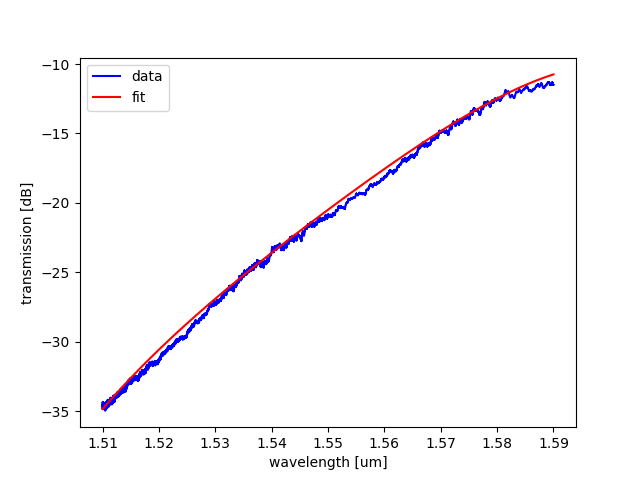

In [18]:
# Reference waveguide:
folder_name = r'../measurement_data_ASP/chip_A/msc_13'
file_name  = 'alignment_center.0_L00_R00.csv'

file_path = os.path.join(folder_name_ref, file_name)

#Reading the .csv file using Pandas
data=pd.read_csv(file_path)

#Extracting the values leaving behind the header.
data = data.values

#Wavelengths and the corresponding measured intensities are the 0th and the 1st columns respectively.
wavelengths_ref = data[:,IDX_WL] * 0.001
measured_ref = data[:,IDX_TDB]

# Use the envelope fitting
from measurement_utils.poly_envelope_fit import poly_envelope_fit
reference_fit = poly_envelope_fit(wavelengths_ref, measured_ref, degree=4)

plt.figure()
plt.plot(wavelengths_ref,measured_ref, 'b', label="data")
plt.plot(wavelengths_ref,np.polyval(reference_fit, wavelengths_ref), 'r', label="fit")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.legend()
plt.show()

In [18]:
#Here we start analyzing MZI3 in the frame > msc_13, node 3

## Analyzing MZI3 

<img src="images/MZI2_delay_length_150um.png" width=400>

- For the MZI3 which it has a delay length $\Delta L_1 = 150 \mu m$ <br>
- MZI3 is designed to perform multiple resonances to extract the FSR and group index from it.

- Inspect the output of the MZ3 port: input1 > out2 w.r.t the alignment waveguide reference


<IPython.core.display.Javascript object>


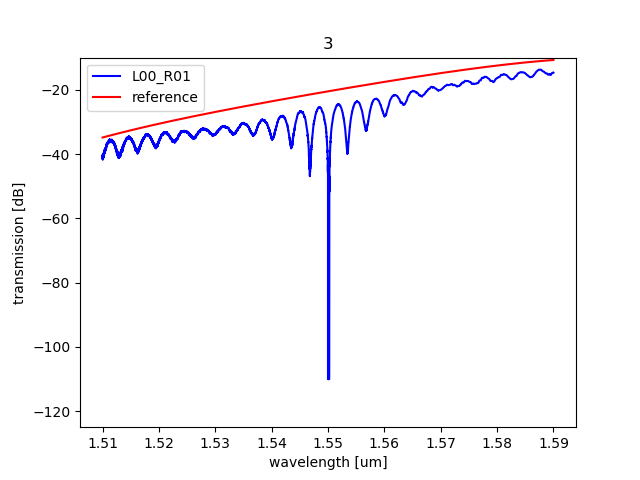

In [123]:
frame_number = MZI3 # Define the frame
port_numbers = ['L00_R00', 'L00_R01', 'L01_R00', 'L01_R01'] # Ports 

data_sets = {} # Store the data

for port_number in port_numbers:
    file_name = 'Double_MZI_Halil_De_Broglie_Double_MZI.{frame}_{port}.csv'.format(frame=frame_number,port=port_number)
    file_path = os.path.join(folder_name, file_name)
    data1=pd.read_csv(file_path)
    data1 = data1.values
    wavelengths1 = data1[:,IDX_WL] * 0.001
    measured1 = data1[:,IDX_TDB]
    measured1 = measured1
    data_sets[port_number] = [wavelengths1, measured1]

    
port_number = 'L00_R01'
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_TDB], 'b',label=port_number)
plt.plot(data_sets[port_number][IDX_WL],np.polyval(reference_fit, data_sets[port_number][IDX_WL]), 'r', label="reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.title(frame_number)
plt.ylim([-125, -10])
plt.legend()
plt.show()

- All Output ports of MZI1 w.r.t waveguide reference 

### Normalize the the transmission spectrum w.r.t reference waveguide
- To do that we convert to linear scale and add up all the input to the two output power in linear scale not in dB.
- Then we convert to dB and fit a 4th order polynomial 

<IPython.core.display.Javascript object>


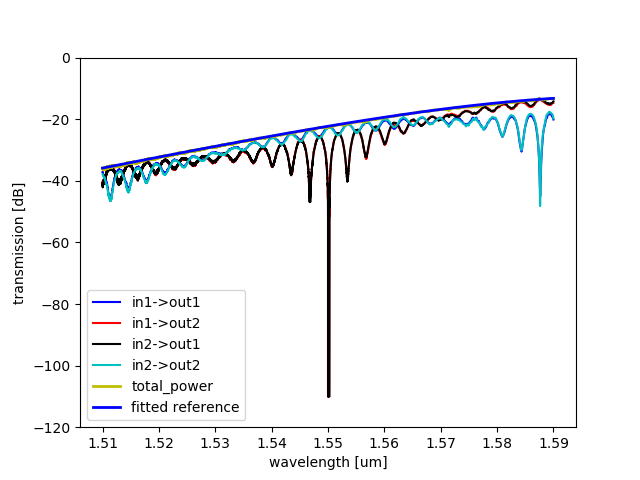

In [124]:
# 1. define a common wavelength set
wavelengths = wavelengths1

# 2. interpolate the 4 transmission curves on those common wavelengths
from scipy.interpolate import interp1d
p11 = interp1d(data_sets['L00_R00'][IDX_WL], data_sets['L00_R00'][IDX_TDB])(wavelengths) #in1->out1
p12 = interp1d(data_sets['L00_R01'][IDX_WL], data_sets['L00_R01'][IDX_TDB])(wavelengths) #in1->out2
p21 = interp1d(data_sets['L01_R00'][IDX_WL], data_sets['L01_R00'][IDX_TDB])(wavelengths) #in2->out1
p22 = interp1d(data_sets['L01_R01'][IDX_WL], data_sets['L01_R01'][IDX_TDB])(wavelengths) #in2->out2

# 3. add it all up and divide by two (on a linear scale)
total_power = 10* np.log10(0.5* (np.power(10, 0.1*p11) + 
                                 np.power(10, 0.1*p12) + 
                                 np.power(10, 0.1*p21) + 
                                 np.power(10, 0.1*p22)
                             ))

# 
reference_fit2 = poly_envelope_fit(wavelengths, total_power, degree=4)


plt.figure()
plt.plot(data_sets['L00_R00'][IDX_WL],data_sets['L00_R00'][IDX_TDB], 'b',label="in1->out1")
plt.plot(data_sets['L00_R01'][IDX_WL],data_sets['L00_R01'][IDX_TDB], 'r',label="in1->out2")
plt.plot(data_sets['L01_R00'][IDX_WL],data_sets['L01_R00'][IDX_TDB], 'k',label="in2->out1")
plt.plot(data_sets['L01_R01'][IDX_WL],data_sets['L01_R01'][IDX_TDB], 'c',label="in2->out2")
plt.plot(wavelengths,total_power, 'y',linewidth=2, label="total_power")
plt.plot(wavelengths,np.polyval(reference_fit2, wavelengths), 'b',linewidth=2, label="fitted reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.ylim([-120, 0])
plt.legend(loc="lower left")
plt.show()

### Figure below show the normlized transmission in dB for MZI3 for port input1>out2

<IPython.core.display.Javascript object>


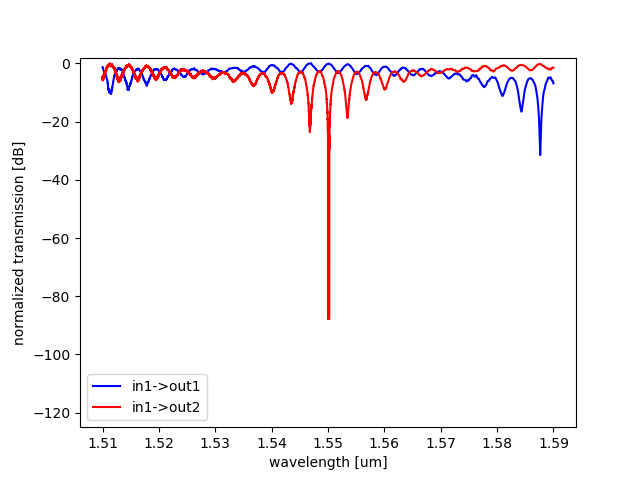

In [125]:
for ds in data_sets.values():
    wavelengths1 = ds[IDX_WL]
    measured1 = ds[IDX_TDB]
    normalized = measured1 - np.polyval(reference_fit2, wavelengths1)
    ds.append(normalized)
        
    ds.append(np.power(10.0, measured1/10.0)) # linear 
    ds.append(np.power(10.0, normalized/10.0)) # linear, normalized
    
plt.figure()
plt.plot(data_sets['L00_R00'][IDX_WL],data_sets['L00_R00'][IDX_NORM_DB], 'b',label="in1->out1")
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_NORM_DB], 'r',label="in1->out2")


plt.xlabel("wavelength [um]")
plt.ylabel("normalized transmission [dB]")
plt.ylim([-125, 2])
plt.legend()
plt.show()

## To extract the pick wavelength transmission  
- First we convert to linear scale
- then we zoom in for range 1.54-1.56
- Then we use autocorrleation to locate local maxima

<IPython.core.display.Javascript object>


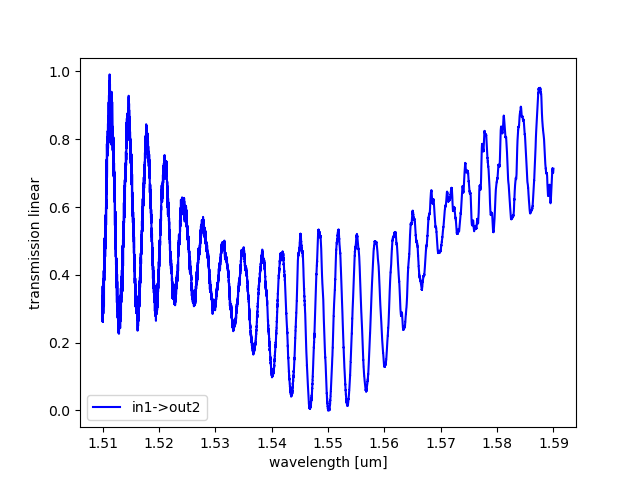

In [126]:
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],np.power(10.0, data_sets[port_number][IDX_NORM_DB]/10.0), 'b',label="in1->out2")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission linear")
plt.legend()
plt.show()

- Zoom for range 1.52-1.54

<IPython.core.display.Javascript object>


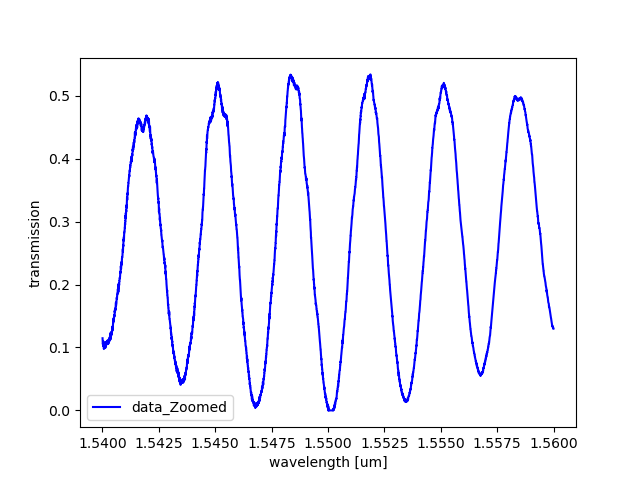

In [128]:
zoom_data_sets = {}

for name, data in data_sets.items():
    # select only the data points with the selected wavelength range
    wl = data[0]
    zoom_data_sets[name] =[col[(wl>1.54) * (wl<1.56)] for col in data]  
                         
    
plt.figure()
plt.plot(zoom_data_sets[port_number][IDX_WL],zoom_data_sets[port_number][IDX_NORM_LIN], 'b',label="data_Zoomed")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission")
plt.legend()
plt.show()

- Autocorrelation functions are a good first approximation to analyze time series data


<IPython.core.display.Javascript object>


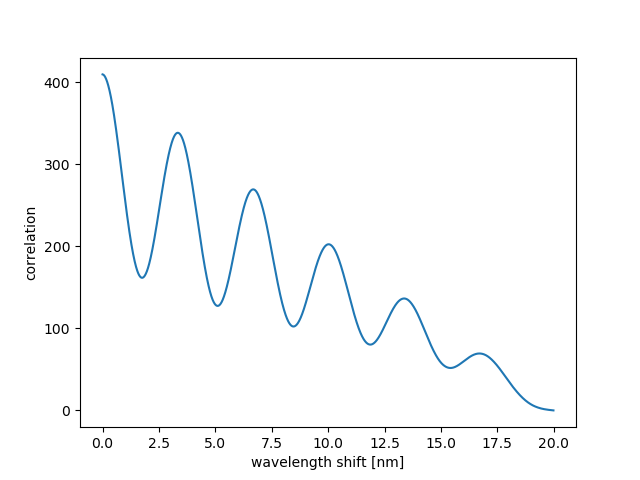

In [129]:
corr = np.correlate(zoom_data_sets[port_number][IDX_NORM_LIN], zoom_data_sets[port_number][IDX_NORM_LIN], mode='full')
delta_wl = zoom_data_sets[port_number][IDX_WL] - zoom_data_sets[port_number][IDX_WL][0]

plt.figure()
plt.plot(delta_wl * 1000, 
         corr[len(corr)/2:])
plt.xlabel("wavelength shift [nm]")
plt.ylabel("correlation")
plt.show()

We can extract the FSR from the first maximum

In [130]:
#Extract the local relative maxima
from scipy.signal import argrelmax # detects local (relative) maxima

fsr_wavelengths = delta_wl[argrelmax(corr[len(corr)/2:])]
FSR_measured = fsr_wavelengths[0]
print fsr_wavelengths
print "The measured FSR is", FSR_measured * 1000, "nm"


[ 0.003335  0.00668   0.010025  0.01337   0.01671 ]
The measured FSR is 3.335 nm


To compare with the designed FSR:

$FSR = \dfrac{\lambda_0^2}{n_g.\Delta L}$

In [131]:
L_delay = delta_L2 #The length of the MZI we designed
print "L_delay",L_delay

FSR_designed = 1.55**2 / (wt_cm.n_g * L_delay)

print "The designed FSR is", FSR_designed * 1000, "nm"

Precenetage_difference_FSR = ((FSR_designed-FSR_measured)/((FSR_measured+FSR_designed)/2))*100
print "The percentage difference between the measured and designed FSR", Precenetage_difference_FSR, "%"

L_delay 150
The designed FSR is 3.82377985214 nm
The percentage difference between the measured and designed FSR 13.6553955349 %


The delay length of MZI is known so, we can calculate the group index of the waveguide:

$n_g = \dfrac{\lambda_0^2}{FSR.\Delta L}$

In [132]:
n_g_measured = 1.55**2 / (FSR_measured * L_delay)

print "Measured group index :", n_g_measured
print "Designed group index :", wt_cm.n_g

Measured group index : 4.80259870065
Designed group index : 4.1887


<IPython.core.display.Javascript object>


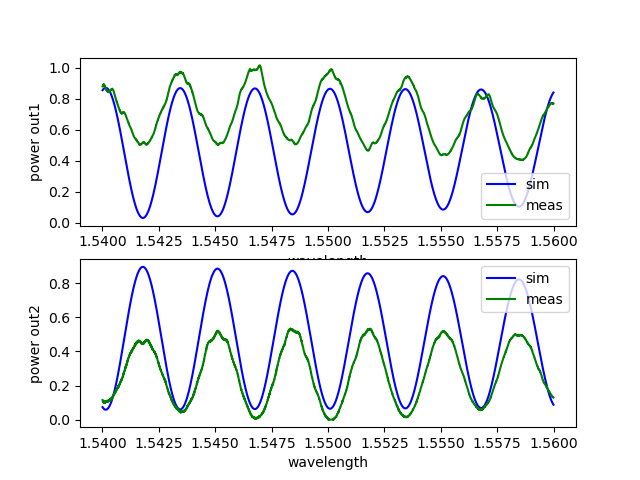

In [133]:
wavelengths = zoom_data_sets['L00_R00'][IDX_WL] 

# Model of the waveguide
model_class = pdk.WG450._templated_class.get_default_view(i3.CircuitModelView)

# list of circuit parameters to be overridden
circuit_parameters = {}

# find all the nodes of type waveguide
#MZI_2_cm is defined as the MZI which has delay length = 150um
for node_name in MZI_2_cm.VE_get_leaf_nodes_of_type(model_class):
    # set the n_g in the circuit with the value extracted from measurements.
    circuit_parameters[node_name] = {"n_g": n_g_measured}

# override all the group indices in the waveguide nodes
MZI_2_cm.VE_assign_parameters_for_smatrix(circuit_parameters)

# resimulate the S-matrix
S = MZI_2_cm.VE_get_smatrix(wavelengths)

plt.figure()
plt.subplot(2,1,1)
plt.plot(wavelengths, np.abs(S["in1", "out1"])**2, "b", label="sim")
plt.plot(zoom_data_sets['L00_R00'][IDX_WL], zoom_data_sets['L00_R00'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out1")
plt.legend()

plt.subplot(2,1,2)
plt.plot(wavelengths, np.abs(S["in1", "out2"])**2, "b", label="sim")
plt.plot(zoom_data_sets['L00_R01'][IDX_WL], zoom_data_sets['L00_R01'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out2")
plt.legend()
plt.show()


# Low Order MZI with delay 15um

<IPython.core.display.Javascript object>


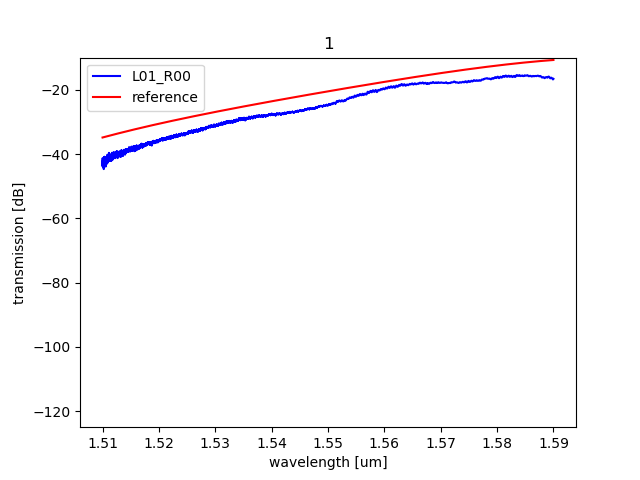

In [200]:
frame_number = MZI1 # Define the frame
port_numbers = ['L00_R00', 'L00_R01', 'L01_R00', 'L01_R01'] # Ports 

data_sets = {} # Store the data

for port_number in port_numbers:
    file_name = 'Double_MZI_Halil_De_Broglie_Double_MZI.{frame}_{port}.csv'.format(frame=frame_number,port=port_number)
    file_path = os.path.join(folder_name, file_name)
    data1=pd.read_csv(file_path)
    data1 = data1.values
    wavelengths1 = data1[:,IDX_WL] * 0.001
    measured1 = data1[:,IDX_TDB]
    measured1 = measured1
    data_sets[port_number] = [wavelengths1, measured1]

    
port_number = 'L01_R00'
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_TDB], 'b',label=port_number)
plt.plot(data_sets[port_number][IDX_WL],np.polyval(reference_fit, data_sets[port_number][IDX_WL]), 'r', label="reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.title(frame_number)
plt.ylim([-125, -10])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


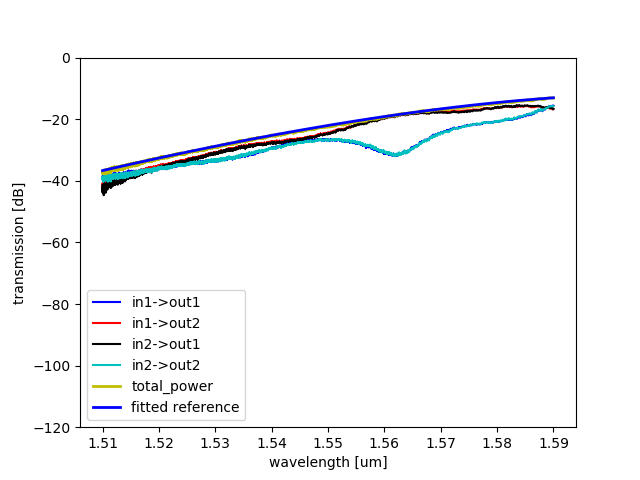

In [201]:
# 1. define a common wavelength set
wavelengths = wavelengths1

# 2. interpolate the 4 transmission curves on those common wavelengths
from scipy.interpolate import interp1d
p11 = interp1d(data_sets['L00_R00'][IDX_WL], data_sets['L00_R00'][IDX_TDB])(wavelengths) #in1->out1
p12 = interp1d(data_sets['L00_R01'][IDX_WL], data_sets['L00_R01'][IDX_TDB])(wavelengths) #in1->out2
p21 = interp1d(data_sets['L01_R00'][IDX_WL], data_sets['L01_R00'][IDX_TDB])(wavelengths) #in2->out1
p22 = interp1d(data_sets['L01_R01'][IDX_WL], data_sets['L01_R01'][IDX_TDB])(wavelengths) #in2->out2

# 3. add it all up and divide by two (on a linear scale)
total_power = 10* np.log10(0.5* (np.power(10, 0.1*p11) + 
                                 np.power(10, 0.1*p12) + 
                                 np.power(10, 0.1*p21) + 
                                 np.power(10, 0.1*p22)
                             ))

# 
reference_fit2 = poly_envelope_fit(wavelengths, total_power, degree=4)


plt.figure()
plt.plot(data_sets['L00_R00'][IDX_WL],data_sets['L00_R00'][IDX_TDB], 'b',label="in1->out1")
plt.plot(data_sets['L00_R01'][IDX_WL],data_sets['L00_R01'][IDX_TDB], 'r',label="in1->out2")
plt.plot(data_sets['L01_R00'][IDX_WL],data_sets['L01_R00'][IDX_TDB], 'k',label="in2->out1")
plt.plot(data_sets['L01_R01'][IDX_WL],data_sets['L01_R01'][IDX_TDB], 'c',label="in2->out2")
plt.plot(wavelengths,total_power, 'y',linewidth=2, label="total_power")
plt.plot(wavelengths,np.polyval(reference_fit2, wavelengths), 'b',linewidth=2, label="fitted reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.ylim([-120, 0])
plt.legend(loc="lower left")
plt.show()

<IPython.core.display.Javascript object>


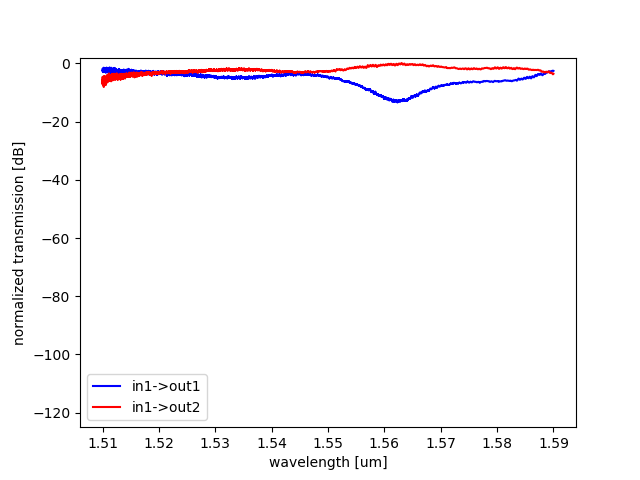

In [202]:
for ds in data_sets.values():
    wavelengths1 = ds[IDX_WL]
    measured1 = ds[IDX_TDB]
    normalized = measured1 - np.polyval(reference_fit2, wavelengths1)
    ds.append(normalized)
        
    ds.append(np.power(10.0, measured1/10.0)) # linear 
    ds.append(np.power(10.0, normalized/10.0)) # linear, normalized
    
plt.figure()
plt.plot(data_sets['L00_R00'][IDX_WL],data_sets['L00_R00'][IDX_NORM_DB], 'b',label="in1->out1")
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_NORM_DB], 'r',label="in1->out2")


plt.xlabel("wavelength [um]")
plt.ylabel("normalized transmission [dB]")
plt.ylim([-125, 2])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


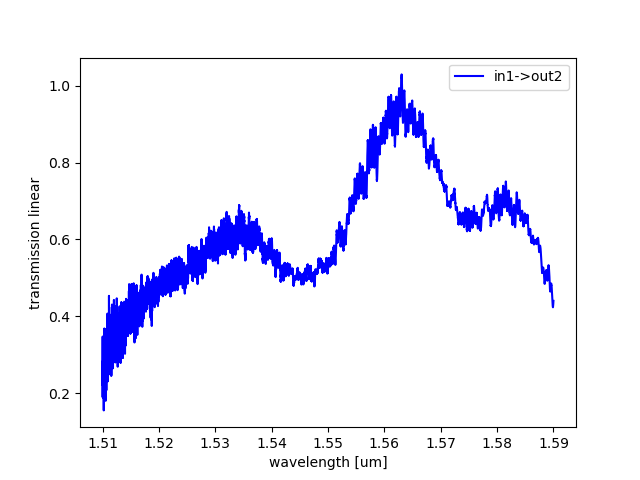

In [203]:
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],np.power(10.0, data_sets[port_number][IDX_NORM_DB]/10.0), 'b',label="in1->out2")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission linear")
plt.legend()
plt.show()

In [204]:
n_eff = wt_cm.n_eff

MZI_1_order = (n_eff * delta_L1) / 1.566
print "MZI_1 order", MZI_1_order

MZI_1 order 22.0252873563


<IPython.core.display.Javascript object>


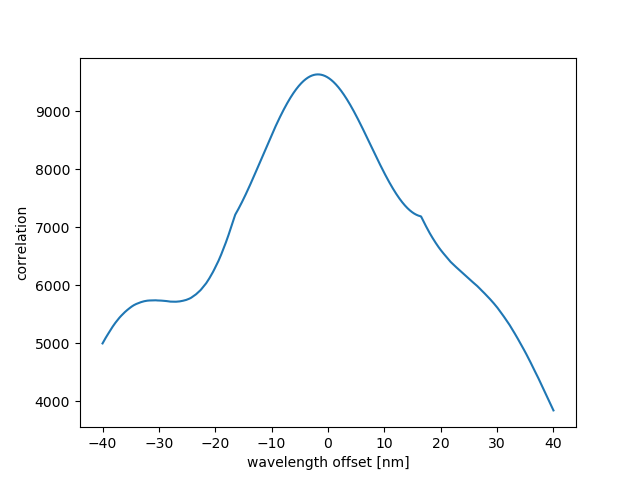

In [205]:
#Make sure to call the right smatrix MZI
S = MZI_1_cm.VE_get_smatrix(wavelengths)

# Model of the waveguide
model_class = pdk.WG450._templated_class.get_default_view(i3.CircuitModelView)

# list of circuit parameters to be overridden
circuit_parameters = {}


corr2 = ( np.correlate(np.abs(S["in1", "out1"])**2,zoom_data_sets['L00_R00'][IDX_NORM_LIN], mode='same') +
          np.correlate(np.abs(S["in1", "out2"])**2,zoom_data_sets['L00_R01'][IDX_NORM_LIN], mode='same') +
          np.correlate(np.abs(S["in2", "out1"])**2,zoom_data_sets['L01_R00'][IDX_NORM_LIN], mode='same') +
          np.correlate(np.abs(S["in2", "out2"])**2,zoom_data_sets['L01_R01'][IDX_NORM_LIN], mode='same') )
# we work on all data sets at the same time

delta_wl = wavelengths - np.mean(wavelengths)

plt.figure()
plt.plot(delta_wl * 1000, 
         corr2)
plt.xlabel("wavelength offset [nm]")
plt.ylabel("correlation")
plt.show()

In [206]:
from scipy.signal import argrelmax # detects local (relative) maxima

offsets = delta_wl[argrelmax(corr2)]
peak_wavelengths = 1.55 - offsets
order_mzi = MZI_1_order

print order_mzi
print peak_wavelengths

22.0252873563
[ 1.5809525  1.5805725  1.5805575  1.5801125  1.5801025  1.5796475
  1.5778725  1.5778375  1.5773325  1.5770575  1.5768075  1.5767975
  1.5767875  1.5767125  1.5517875]


In [207]:
n_effs = peak_wavelengths * order_mzi / delta_L1

print "Possible solutions:"
for wl, n, off in zip(peak_wavelengths, n_effs, offsets):
    print "n_eff =", n , " at wavelength", wl, "um (", off * 1000, "nm offset)"

Possible solutions:
n_eff = 2.32139554061  at wavelength 1.5809525 um ( -30.9525 nm offset)
n_eff = 2.32083756667  at wavelength 1.5805725 um ( -30.5725 nm offset)
n_eff = 2.32081554138  at wavelength 1.5805575 um ( -30.5575 nm offset)
n_eff = 2.32016212452  at wavelength 1.5801125 um ( -30.1125 nm offset)
n_eff = 2.320147441  at wavelength 1.5801025 um ( -30.1025 nm offset)
n_eff = 2.31947934061  at wavelength 1.5796475 um ( -29.6475 nm offset)
n_eff = 2.31687301494  at wavelength 1.5778725 um ( -27.8725 nm offset)
n_eff = 2.31682162261  at wavelength 1.5778375 um ( -27.8375 nm offset)
n_eff = 2.3160801046  at wavelength 1.5773325 um ( -27.3325 nm offset)
n_eff = 2.31567630766  at wavelength 1.5770575 um ( -27.0575 nm offset)
n_eff = 2.31530921954  at wavelength 1.5768075 um ( -26.8075 nm offset)
n_eff = 2.31529453602  at wavelength 1.5767975 um ( -26.7975 nm offset)
n_eff = 2.31527985249  at wavelength 1.5767875 um ( -26.7875 nm offset)
n_eff = 2.31516972605  at wavelength 1.5767125 

In [231]:
NEFF_INDEX=5
Precenetage_difference_n_eff = (np.abs(n_eff-n_effs[NEFF_INDEX])/((n_effs[NEFF_INDEX]+n_eff)/2))*100
print "The percentage difference between the measured and designed n_eff", Precenetage_difference_n_eff, "%"

The percentage difference between the measured and designed n_eff 0.867706887056 %


<IPython.core.display.Javascript object>


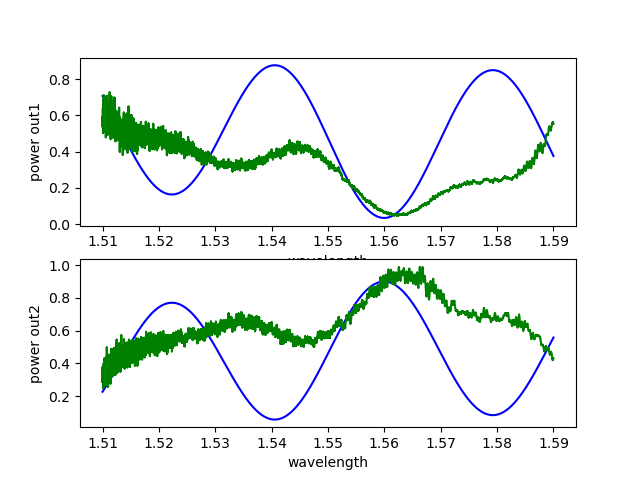

In [232]:
model_class = pdk.WG450._templated_class.get_default_view(i3.CircuitModelView)
circuit_parameters= {}

for node_name in MZI_1_cm.VE_get_leaf_nodes_of_type(model_class):
    circuit_parameters[node_name] = {"n_eff": n_effs[NEFF_INDEX]}
    circuit_parameters[node_name] = {"center_wavelengths": peak_wavelengths[NEFF_INDEX]}
MZI_1_cm.VE_assign_parameters_for_smatrix(circuit_parameters)
S = MZI_1_cm.VE_get_smatrix(wavelengths)

plt.figure()
plt.subplot(2,1,1)
plt.plot(wavelengths, np.abs(S["in1", "out1"])**2, "b", label="sim")
plt.plot(data_sets['L00_R00'][IDX_WL], data_sets['L00_R00'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out1")

plt.subplot(2,1,2)
plt.plot(wavelengths, np.abs(S["in1", "out2"])**2, "b", label="sim")
plt.plot(data_sets['L00_R01'][IDX_WL], data_sets['L00_R01'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out2")
plt.show()

As we can see the difference between the fabricated cicruit and the designed one is quite hight, clearly the fabricated circuit is more dispersive. 

- It is still worth comparing the behavior of the simulated circuit with this value of group index.
- We used Variability Extensions which is used for variability analysis, to assign this group index to all the waveguides in this circuit.

- Variability extensions uses simulator Caphe, to evaluate the effect of process variability on photonic integrated circuits. [more information on Layout-Aware Variability Analysis, Yield Prediction,
and Optimization in Photonic Integrated Circuits
](https://photonics.intec.ugent.be/download/pub_4320.pdf)

#### Implementation
- we identified all the corresponding waveguides
- we override the group index with the value we have just calculated

THAT is really nice :D

This looks like a good match between the FSR of the designed and fabricated circuits

## Analyzing MZI1


<img src="images/MZI1_delay_length_15um.png" width=400>

- For the MZI1 which it has a delay length $\Delta L_1 = 15 \mu m$ <br>
- MZI1 is designed to perform multiple resonances to extract the FSR and group index from it.

In [32]:
wavelengths = np.linspace(1.51, 1.59, 3999) 


<IPython.core.display.Javascript object>


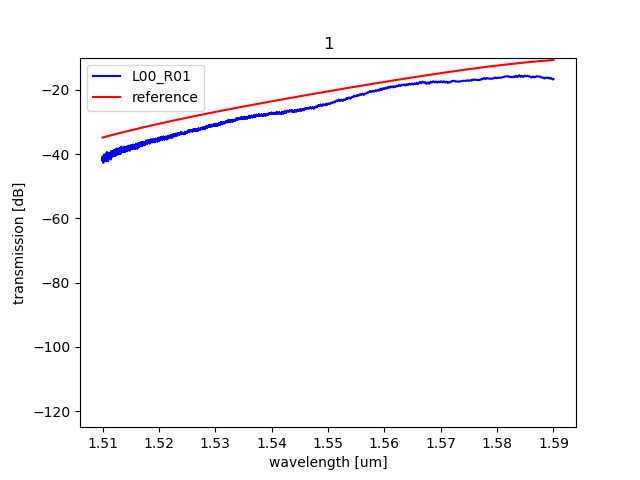

In [33]:
frame_number = MZI1# Define the frame
port_numbers = ['L00_R00', 'L00_R01', 'L01_R00', 'L01_R01'] # Ports 

data_sets = {} # Store the data

for port_number in port_numbers:
    file_name = 'Double_MZI_Halil_De_Broglie_Double_MZI.{frame}_{port}.csv'.format(frame=frame_number,port=port_number)
    file_path = os.path.join(folder_name, file_name)
    data1=pd.read_csv(file_path)
    data1 = data1.values
    wavelengths1 = data1[:,IDX_WL] * 0.001
    measured1 = data1[:,IDX_TDB]
    measured1 = measured1
    data_sets[port_number] = [wavelengths1, measured1]

    
port_number = 'L00_R01'
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_TDB], 'b',label=port_number)
plt.plot(data_sets[port_number][IDX_WL],np.polyval(reference_fit, data_sets[port_number][IDX_WL]), 'r', label="reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.title(frame_number)
plt.ylim([-125, -10])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


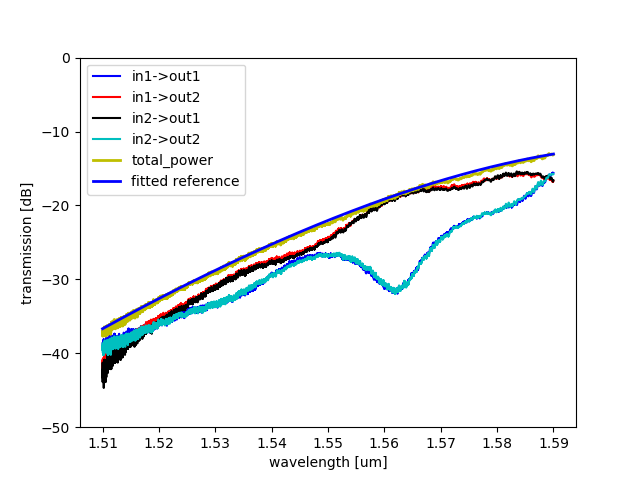

In [34]:
# 1. define a common wavelength set
wavelengths = wavelengths1

# 2. interpolate the 4 transmission curves on those common wavelengths
from scipy.interpolate import interp1d
p11 = interp1d(data_sets['L00_R00'][IDX_WL], data_sets['L00_R00'][IDX_TDB])(wavelengths) #in1->out1
p12 = interp1d(data_sets['L00_R01'][IDX_WL], data_sets['L00_R01'][IDX_TDB])(wavelengths) #in1->out2
p21 = interp1d(data_sets['L01_R00'][IDX_WL], data_sets['L01_R00'][IDX_TDB])(wavelengths) #in2->out1
p22 = interp1d(data_sets['L01_R01'][IDX_WL], data_sets['L01_R01'][IDX_TDB])(wavelengths) #in2->out2

# 3. add it all up and divide by two (on a linear scale)
total_power = 10* np.log10(0.5* (np.power(10, 0.1*p11) + 
                                 np.power(10, 0.1*p12) + 
                                 np.power(10, 0.1*p21) + 
                                 np.power(10, 0.1*p22)
                             ))

# 
reference_fit2 = poly_envelope_fit(wavelengths, total_power, degree=4)


plt.figure()
plt.plot(data_sets['L00_R00'][IDX_WL],data_sets['L00_R00'][IDX_TDB], 'b',label="in1->out1")
plt.plot(data_sets['L00_R01'][IDX_WL],data_sets['L00_R01'][IDX_TDB], 'r',label="in1->out2")
plt.plot(data_sets['L01_R00'][IDX_WL],data_sets['L01_R00'][IDX_TDB], 'k',label="in2->out1")
plt.plot(data_sets['L01_R01'][IDX_WL],data_sets['L01_R01'][IDX_TDB], 'c',label="in2->out2")
plt.plot(wavelengths,total_power, 'y',linewidth=2, label="total_power")
plt.plot(wavelengths,np.polyval(reference_fit2, wavelengths), 'b',linewidth=2, label="fitted reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.ylim([-50, 0])
plt.legend(loc="upper left")
plt.show()

<IPython.core.display.Javascript object>


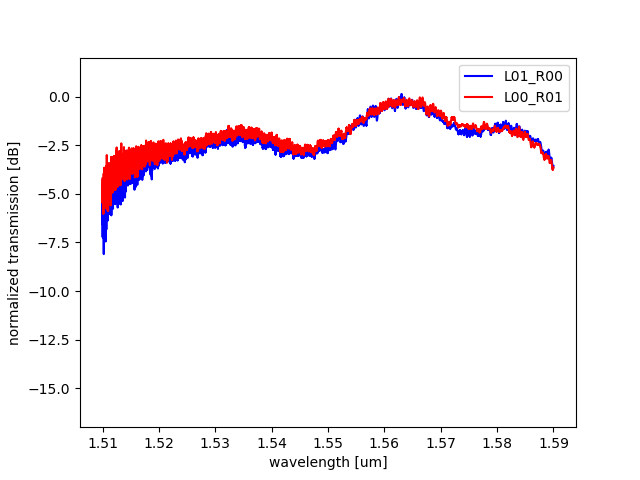

In [35]:
for ds in data_sets.values():
    wavelengths1 = ds[IDX_WL]
    measured1 = ds[IDX_TDB]
    normalized = measured1 - np.polyval(reference_fit2, wavelengths1)
    ds.append(normalized)
        
    ds.append(np.power(10.0, measured1/10.0)) # linear 
    ds.append(np.power(10.0, normalized/10.0)) # linear, normalized
    
plt.figure()
plt.plot(data_sets['L01_R00'][IDX_WL],data_sets['L01_R00'][IDX_NORM_DB], 'b',label="L01_R00")
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_NORM_DB], 'r',label=port_number)


plt.xlabel("wavelength [um]")
plt.ylabel("normalized transmission [dB]")
plt.ylim([-17, 2])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


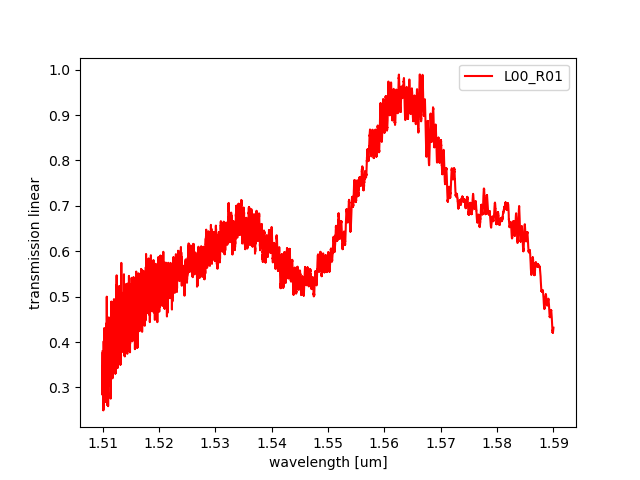

In [36]:
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],np.power(10.0, data_sets[port_number][IDX_NORM_DB]/10.0), 'r',label=port_number)
plt.xlabel("wavelength [um]")
plt.ylabel("transmission linear")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


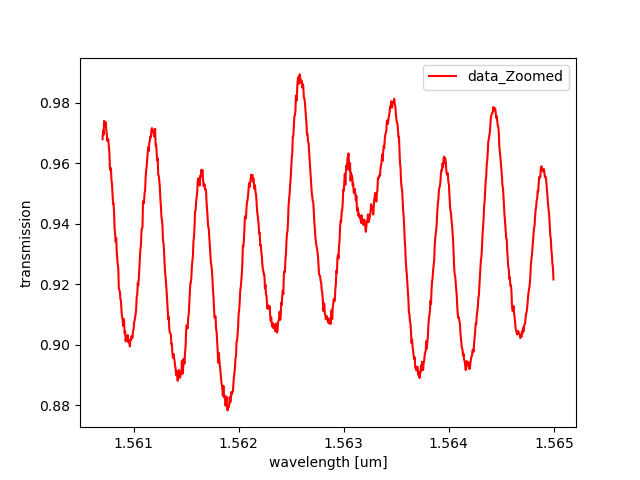

In [37]:
zoom_data_sets = {}

for name, data in data_sets.items():
    # select only the data points with the selected wavelength range
    wl = data[0]
    zoom_data_sets[name] =[col[(wl>1.5607) * (wl<1.565)] for col in data]  
                         
    
plt.figure()
plt.plot(zoom_data_sets[port_number][IDX_WL],zoom_data_sets[port_number][IDX_NORM_LIN], 'r',label="data_Zoomed")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


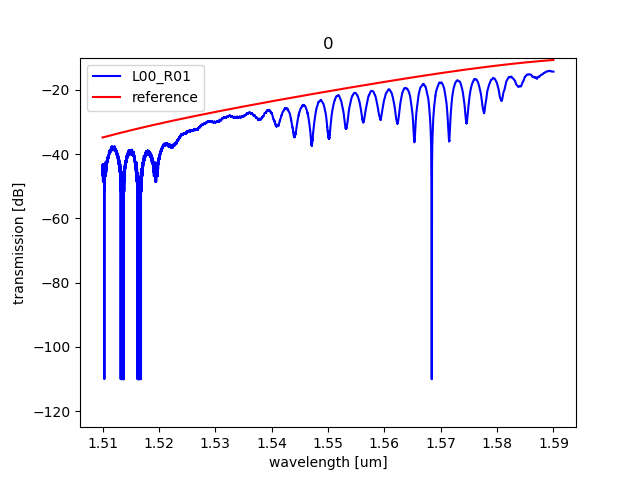

In [97]:
frame_number = MZI0# Define the frame
port_numbers = ['L00_R00', 'L00_R01', 'L01_R00', 'L01_R01'] # Ports 

data_sets = {} # Store the data

for port_number in port_numbers:
    file_name = 'Double_MZI_Halil_De_Broglie_Double_MZI.{frame}_{port}.csv'.format(frame=frame_number,port=port_number)
    file_path = os.path.join(folder_name, file_name)
    data1=pd.read_csv(file_path)
    data1 = data1.values
    wavelengths1 = data1[:,IDX_WL] * 0.001
    measured1 = data1[:,IDX_TDB]
    measured1 = measured1
    data_sets[port_number] = [wavelengths1, measured1]

    
port_number = 'L00_R01'
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_TDB], 'b',label=port_number)
plt.plot(data_sets[port_number][IDX_WL],np.polyval(reference_fit, data_sets[port_number][IDX_WL]), 'r', label="reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.title(frame_number)
plt.ylim([-125, -10])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


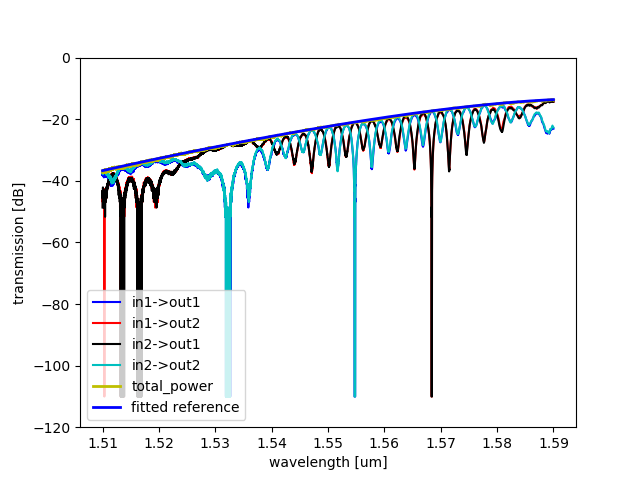

In [98]:
# 1. define a common wavelength set
wavelengths = wavelengths1

# 2. interpolate the 4 transmission curves on those common wavelengths
from scipy.interpolate import interp1d
p11 = interp1d(data_sets['L00_R00'][IDX_WL], data_sets['L00_R00'][IDX_TDB])(wavelengths) #in1->out1
p12 = interp1d(data_sets['L00_R01'][IDX_WL], data_sets['L00_R01'][IDX_TDB])(wavelengths) #in1->out2
p21 = interp1d(data_sets['L01_R00'][IDX_WL], data_sets['L01_R00'][IDX_TDB])(wavelengths) #in2->out1
p22 = interp1d(data_sets['L01_R01'][IDX_WL], data_sets['L01_R01'][IDX_TDB])(wavelengths) #in2->out2

# 3. add it all up and divide by two (on a linear scale)
total_power = 10* np.log10(0.5* (np.power(10, 0.1*p11) + 
                                 np.power(10, 0.1*p12) + 
                                 np.power(10, 0.1*p21) + 
                                 np.power(10, 0.1*p22)
                             ))

# 
reference_fit2 = poly_envelope_fit(wavelengths, total_power, degree=4)


plt.figure()
plt.plot(data_sets['L00_R00'][IDX_WL],data_sets['L00_R00'][IDX_TDB], 'b',label="in1->out1")
plt.plot(data_sets['L00_R01'][IDX_WL],data_sets['L00_R01'][IDX_TDB], 'r',label="in1->out2")
plt.plot(data_sets['L01_R00'][IDX_WL],data_sets['L01_R00'][IDX_TDB], 'k',label="in2->out1")
plt.plot(data_sets['L01_R01'][IDX_WL],data_sets['L01_R01'][IDX_TDB], 'c',label="in2->out2")
plt.plot(wavelengths,total_power, 'y',linewidth=2, label="total_power")
plt.plot(wavelengths,np.polyval(reference_fit2, wavelengths), 'b',linewidth=2, label="fitted reference")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.ylim([-120, 0])
plt.legend(loc="lower left")
plt.show()

<IPython.core.display.Javascript object>


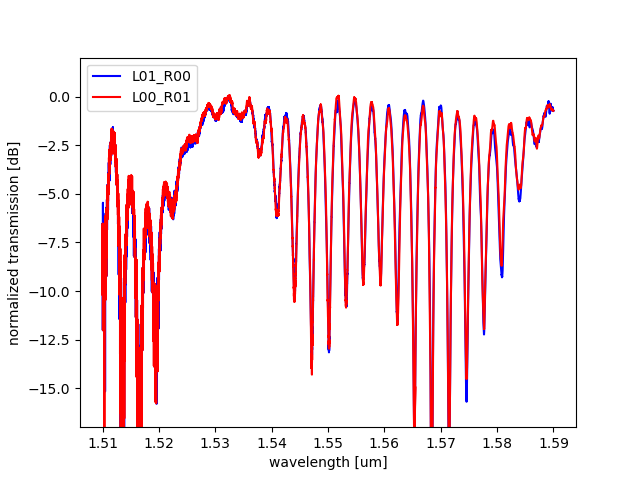

In [99]:
for ds in data_sets.values():
    wavelengths1 = ds[IDX_WL]
    measured1 = ds[IDX_TDB]
    normalized = measured1 - np.polyval(reference_fit2, wavelengths1)
    ds.append(normalized)
        
    ds.append(np.power(10.0, measured1/10.0)) # linear 
    ds.append(np.power(10.0, normalized/10.0)) # linear, normalized
    
plt.figure()
plt.plot(data_sets['L01_R00'][IDX_WL],data_sets['L01_R00'][IDX_NORM_DB], 'b',label="L01_R00")
plt.plot(data_sets[port_number][IDX_WL],data_sets[port_number][IDX_NORM_DB], 'r',label=port_number)


plt.xlabel("wavelength [um]")
plt.ylabel("normalized transmission [dB]")
plt.ylim([-17, 2])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


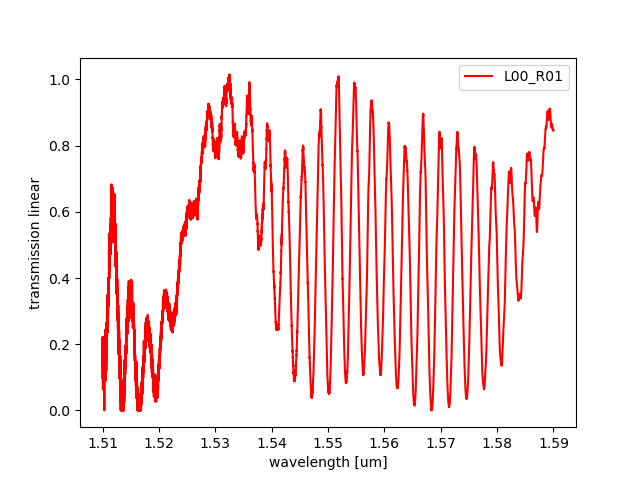

In [100]:
plt.figure()
plt.plot(data_sets[port_number][IDX_WL],np.power(10.0, data_sets[port_number][IDX_NORM_DB]/10.0), 'r',label=port_number)
plt.xlabel("wavelength [um]")
plt.ylabel("transmission linear")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


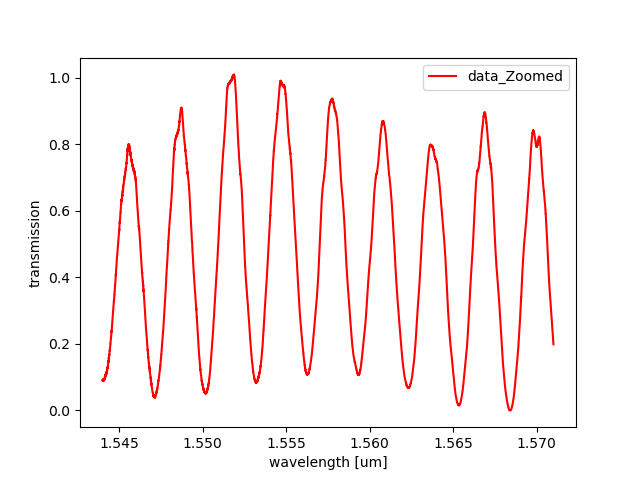

In [101]:
zoom_data_sets = {}

for name, data in data_sets.items():
    # select only the data points with the selected wavelength range
    wl = data[0]
    zoom_data_sets[name] =[col[(wl>1.544) * (wl<1.571)] for col in data]  
                         
    
plt.figure()
plt.plot(zoom_data_sets[port_number][IDX_WL],zoom_data_sets[port_number][IDX_NORM_LIN], 'r',label="data_Zoomed")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission")
plt.legend()
plt.show()

In [43]:
x= zoom_data_sets[port_number][IDX_NORM_LIN]

In [44]:
df = pd.DataFrame(x)

df.to_csv('myfile2.csv')

<IPython.core.display.Javascript object>


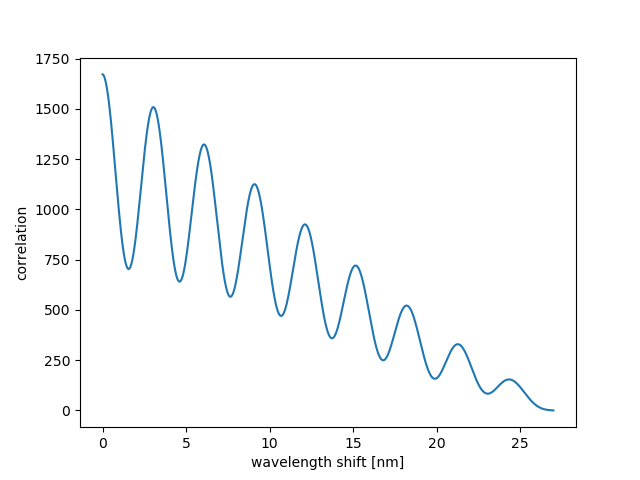

In [102]:
corr = np.correlate(zoom_data_sets[port_number][IDX_NORM_LIN], zoom_data_sets[port_number][IDX_NORM_LIN], mode='full')
delta_wl = zoom_data_sets[port_number][IDX_WL] - zoom_data_sets[port_number][IDX_WL][0]

plt.figure()
plt.plot(delta_wl * 1000, 
         corr[len(corr)/2:])
plt.xlabel("wavelength shift [nm]")
plt.ylabel("correlation")
plt.show()

In [103]:
#Extract the local relative maxima
from scipy.signal import argrelmax # detects local (relative) maxima

fsr_wavelengths = delta_wl[argrelmax(corr[len(corr)/2:])]
FSR_measured = fsr_wavelengths[0]
print fsr_wavelengths
print "The measured FSR is", FSR_measured * 1000, "nm"


[ 0.003045  0.006075  0.009095  0.012115  0.015145  0.0182    0.021265
  0.02433 ]
The measured FSR is 3.045 nm


In [104]:
L_delay = delta_L2 - delta_L1#The length of the MZI we designed
print "L_delay",L_delay

FSR_designed = 1.55**2 / (wt_cm.n_g * L_delay)

print "The designed FSR is", FSR_designed * 1000, "nm"

Precenetage_difference_FSR = ((FSR_designed-FSR_measured)/((FSR_measured+FSR_designed)/2))*100
print "The percentage difference between the measured and designed FSR", Precenetage_difference_FSR, "%"

L_delay 135
The designed FSR is 4.24864428016 nm
The percentage difference between the measured and designed FSR 33.0052915641 %


In [105]:
n_g_measured = 1.55**2 / (FSR_measured * L_delay)

print "Measured group index :", n_g_measured
print "Designed group index :", wt_cm.n_g

Measured group index : 5.84443228121
Designed group index : 4.1887


<IPython.core.display.Javascript object>


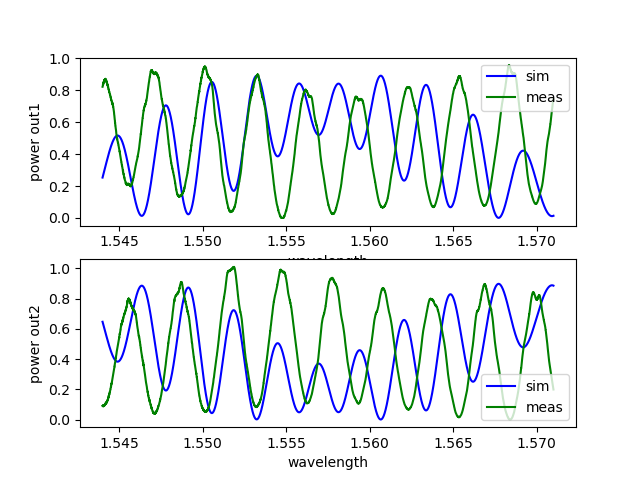

In [106]:
wavelengths = zoom_data_sets['L00_R00'][IDX_WL] 

# Model of the waveguide
model_class = pdk.WG450._templated_class.get_default_view(i3.CircuitModelView)

# list of circuit parameters to be overridden
circuit_parameters = {}

# find all the nodes of type waveguide
#MZI_Double_cm is defined as the MZI which has delay length = 150um
for node_name in MZI_Double_cm.VE_get_leaf_nodes_of_type(model_class):
    # set the n_g in the circuit with the value extracted from measurements.
    circuit_parameters[node_name] = {"n_g": n_g_measured}

# override all the group indices in the waveguide nodes
MZI_Double_cm.VE_assign_parameters_for_smatrix(circuit_parameters)

# resimulate the S-matrix
S = MZI_Double_cm.VE_get_smatrix(wavelengths)

plt.figure()
plt.subplot(2,1,1)
plt.plot(wavelengths, np.abs(S["in1", "out1"])**2, "b", label="sim")
plt.plot(zoom_data_sets['L00_R00'][IDX_WL], zoom_data_sets['L00_R00'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out1")
plt.legend()

plt.subplot(2,1,2)
plt.plot(wavelengths, np.abs(S["in1", "out2"])**2, "b", label="sim")
plt.plot(zoom_data_sets['L00_R01'][IDX_WL], zoom_data_sets['L00_R01'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out2")
plt.legend()
plt.show()


In [109]:
S

<IPython.core.display.Javascript object>


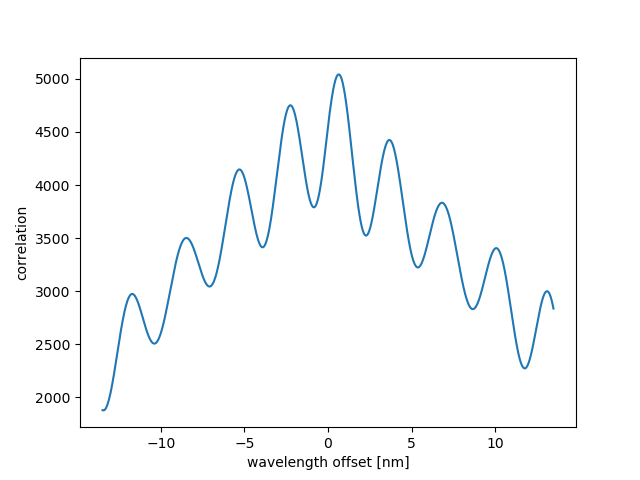

In [107]:
corr2 = ( np.correlate(np.abs(S["in1", "out1"])**2,zoom_data_sets['L00_R00'][IDX_NORM_LIN], mode='same') +
          np.correlate(np.abs(S["in1", "out2"])**2,zoom_data_sets['L00_R01'][IDX_NORM_LIN], mode='same') +
          np.correlate(np.abs(S["in2", "out1"])**2,zoom_data_sets['L01_R00'][IDX_NORM_LIN], mode='same') +
          np.correlate(np.abs(S["in2", "out2"])**2,zoom_data_sets['L01_R01'][IDX_NORM_LIN], mode='same') )
# we work on all data sets at the same time

delta_wl = wavelengths - np.mean(wavelengths)

plt.figure()
plt.plot(delta_wl * 1000, 
         corr2)
plt.xlabel("wavelength offset [nm]")
plt.ylabel("correlation")
plt.show()

In [122]:
offsets = delta_wl[argrelmax(corr2)]
peak_wavelengths = 1.55 - offsets

print peak_wavelengths

[ 1.56172   1.55848   1.555305  1.55225   1.54936   1.54633   1.54318
  1.53993   1.53689 ]


In [141]:
print "Possible solutions:"
for wl, n, off in zip(peak_wavelengths, n_effs, offsets):
    print "n_eff =", n , " at wavelength", wl, "um (", off * 1000, "nm offset)"

Possible solutions:
n_eff = 2.25854178415  at wavelength 1.56172 um ( -11.72 nm offset)
n_eff = 2.25385613283  at wavelength 1.55848 um ( -8.48 nm offset)
n_eff = 2.24926448377  at wavelength 1.555305 um ( -5.305 nm offset)
n_eff = 2.24484637736  at wavelength 1.55225 um ( -2.25 nm offset)
n_eff = 2.24066689208  at wavelength 1.54936 um ( 0.64 nm offset)
n_eff = 2.23628494038  at wavelength 1.54633 um ( 3.67 nm offset)
n_eff = 2.23172944604  at wavelength 1.54318 um ( 6.82 nm offset)
n_eff = 2.22702933283  at wavelength 1.53993 um ( 10.07 nm offset)
n_eff = 2.22263291925  at wavelength 1.53689 um ( 13.11 nm offset)


<IPython.core.display.Javascript object>


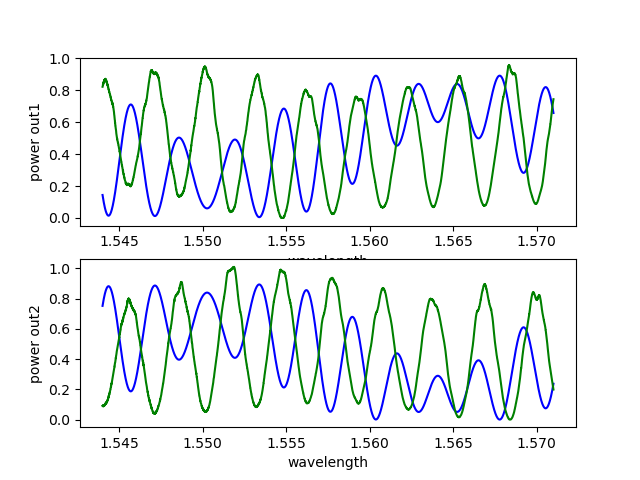

In [142]:
NEFF_INDEX = 10  # which of these effective index estimates will we try?

for node_name in MZI_Double_cm.VE_get_leaf_nodes_of_type(model_class):
    circuit_parameters[node_name]["n_eff"] = n_effs[NEFF_INDEX]
    circuit_parameters[node_name]["center_wavelengths"] = peak_wavelengths[NEFF_INDEX]
MZI_Double_cm.VE_assign_parameters_for_smatrix(circuit_parameters)
S = MZI_Double_cm.VE_get_smatrix(wavelengths)

plt.figure()
plt.subplot(2,1,1)
plt.plot(wavelengths, np.abs(S["in1", "out1"])**2, "b", label="sim")
plt.plot(zoom_data_sets['L00_R00'][IDX_WL], zoom_data_sets['L00_R00'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out1")

plt.subplot(2,1,2)
plt.plot(wavelengths, np.abs(S["in1", "out2"])**2, "b", label="sim")
plt.plot(zoom_data_sets['L00_R01'][IDX_WL], zoom_data_sets['L00_R01'][IDX_NORM_LIN], "g", label="meas")
plt.xlabel("wavelength")
plt.ylabel("power out2")
plt.show()